2.スクラッチによる実装
NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

# 【問題1】ロジスティック回帰のクラスを作成する
ロジスティック回帰のクラスを作成し、Sprint2で作成した分類のパイプラインに組み込んでください。

クラスの基本構造はSprint3の線形回帰を参考にし、名前はScratchLogisticRegressionとしてください。

メソッドやパラメータなどはscikit-learnを参考にしてください。推定関係ではラベルを出力するpredictメソッドと、確率を出力するpredict_probaメソッドの2種類を作成します。

sklearn.linear_model.LinearRegression — scikit-learn 0.20.0 documentation

検証段階ではJupyter Notebook上で書いていき、最終的にはpyファイルにモジュールとしてまとめてください。

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

In [3]:
import sys
sys.path.append("/Users/morio/diveintocode-ml/ml-scratch")
from utils.ScratchLinearRegression import ScratchLinearRegression

In [4]:
df_train = pd.read_csv("/Users/morio/diveintocode-ml/input/week4/train.csv")
#columns = ["GrLivArea", "YearBuilt", "SalePrice"]
#df_train2 = df_train[columns]
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
import numpy as np
import math
from sklearn.metrics import accuracy_score
import copy 
import matplotlib.pyplot as plt
%matplotlib inline

class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    bias : bool
      バイアス項を入れる場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue
    lambda : float
      正則化パラメーター

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,1)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      学習用データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証用データに対する損失の記録
    self.n : int
      特徴量の数(バイアス含む)

    """

    def __init__(self, num_iter=500, lr=0.05, lam=0.02, bias=True, verbose=True):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.lam = lam
        self.bias = bias
        self.verbose = verbose
        self.n = 0
        self.coef_ = 0
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        線形回帰を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        # バイアスの処理
        if self.bias:
            m = len(X)
            X = np.hstack((np.ones(m).reshape(m, 1), X))

            # X_valにもバイアスの追加
            if type(X_val) == np.ndarray:
                m_val = len(X_val)
                X_val = np.hstack((np.ones(m_val).reshape(m_val, 1), X_val))

        # 特徴量の数取得
        self.n = X.shape[1]
        # シータの初期化
        self._init_theta()
        # 勾配降下
        self._gradient_descent(X, y, X_val, y_val)
        
    def _sigmoid(self, z):
        """
        Parameters
        ---------
        z : np.array
        
        Returns
        -------
        g:  np.array
            sigmoid関数にzを入力した値
        """
        
        g = 1 / (1 + np.e**-z)
        return g

    def _init_theta(self):
        """
        self.coef_ : 次の形のndarray, shape (n_features,)
        パラメータ
        をランダムに初期化します。
        """
        self.coef_ = np.random.rand(self.n, 1)
        # self.coef_ = np.zeros(self.n).reshape(self.n, 1)

    def predict(self, X):
        """
        ロジスティクス回帰を使い推定する。
        roundで整数化し返す。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティクス回帰による推定結果
        """

        if self.bias:
            m = len(X)
            X = np.hstack((np.ones(m).reshape(m, 1), X))
        
        hx = self._sigmoid(np.dot(X, self.coef_))
        
        #閾値でTrue,Falseで変換して,intに変換
        pred = (hx >= 0.5).astype(int)

        return pred
    
    def predict_proba(self, X):
        """
        ロジスティクス回帰を使い推定する。
        確率を返す。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティクス回帰による推定結果
        """
        
        if self.bias:
            m = len(X)
            X = np.hstack((np.ones(m).reshape(m, 1), X))

        hx = self._sigmoid(np.dot(X, self.coef_))

        return hx

    def _linear_hypothesis(self, X):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ

        Returns
        -------
        hx:  次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        
        hx = self._sigmoid(np.dot(X, self.coef_))

        return hx

    def _compute_cost(self, hx, y):
        """
        コスト関数を計算して返す

        Parameters
        ----------
        hx : 次の形のndarray, shape (n_samples, １)
          学習データ
        y : 次の形のndarray, shape (n_samples, 1)
          正解値

        Returns
        -------
         J : 次の形のndarray, shape (1,)
          平均二乗誤差
        """
        #hxはシグモイドにX*theta.T入れたもの
        #hx = self._linear_hypothesis(X)
        m = len(y)
        y = y.reshape(m, 1)  # リシェイプ
        theta =  copy.deepcopy(self.coef_)
        
        if self.bias:
            theta[0] = 0 #バイアス項は正則化しないため、ゼロを入れる
            
        J = 1 / m * sum(sum(-y * np.log(hx) - (1- y)*np.log(1 - hx))) + self.lam / (2 * m) * sum(theta**2)

        return J
    
    def _gradient_descent(self, X, y, X_val=None, y_val=None):
        """
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ
        y : 次の形のndarray, shape (n_samples, 1)
          正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        alpha = self.lr
        m = len(X)
        #y = y[:, np.newaxis]  # newaxisで縦ベクトルに変換
        y = y.reshape(m, 1)  # リシェイプ
        hx = self._linear_hypothesis(X) #シグモイド済み

        for i in range(self.iter):
            theta = copy.deepcopy(self.coef_)
            if self.bias:
                theta[0] = 0 #バイアス項は正則化しないため、ゼロを入れる

            self.coef_ = self.coef_ - (alpha * (1 / m) * np.dot(X.T, (hx - y)) + self.lam / m * theta)
            hx = self._linear_hypothesis(X)
            
            # trainデータのlossのリザルトを出す
            if self.verbose:
                self.loss[i] = self._compute_cost(hx, y)

            # X_val入力ある場合MSEのリザルトをだす
            if type(X_val) == np.ndarray:
                val_pred = self._linear_hypothesis(X_val)
                self.val_loss[i] = self._compute_cost(val_pred, y_val)


    def plot_loss_train_and_val(self):
        """
        学習曲線をプロットします。

        loss : array
        一回ごとの勾配降下方のロスのログ(train)
         val_los : array
        一回ごとの勾配降下方のロスのログ(val or test)
        """
        plt.figure(figsize=(8, 5))
        plt.title("model_loss")
        plt.xlabel("iter")
        plt.ylabel("loss")
        plt.plot(self.loss, label="train_loss")
        plt.plot(self.val_loss, label="val_loss")
        plt.yscale("log")
        plt.legend()
    
    def accuracy(self, y_test, y_pred):
        #accuracyを計算して返す
        return accuracy_score(y_test, y_pred)
    
    ##下の関数はメモです
    def validator(theta):
        #(x,y)におけるy軸。
        #シグモイド関数では θTxa=0 が分類AとBの境界だったので、その時の値を求めてプロットする。
        #θTx = θ0＊x0 + θ1＊x1 + θ2＊x2 = 0
        #x2  = -(θ0 + θ1＊x1) / θ2
        xline = np.linspace(-4,4,100) #X１の線
        budary = -(theta[1] + theta[2] * xline) / theta[2]

        return budary

In [6]:
#シンプルデータセット
X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [7]:
#アイリスデータの取り込み
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names) #Dataframe ”X”を作成
columns = ["petal length (cm)", "petal width (cm)"]
X = X[columns]
X["TARGET"] = iris.target
X = X[X["TARGET"] < 2]
y = X["TARGET"].values
X = X.drop("TARGET", axis = 1).values

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

In [10]:
model = ScratchLogisticRegression(lam=0.1, num_iter=5000)

In [11]:
model.fit(X_train, y_train, X_test, y_test)

In [12]:
model.coef_

array([[0.09958591],
       [1.56157157],
       [1.58946637]])

In [13]:
from sklearn.linear_model import LogisticRegression
 
# 訓練
lr = LogisticRegression(C=10,fit_intercept=True, max_iter=500)
LogisticRegression()
lr.fit(X_train, y_train)

/Users/morio/.pyenv/versions/anaconda3-5.3.0/envs/python-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [14]:
lr.coef_

array([[3.06666032, 3.17749511]])

# 【問題2】学習曲線のプロット
学習曲線をプロットしてしてください。

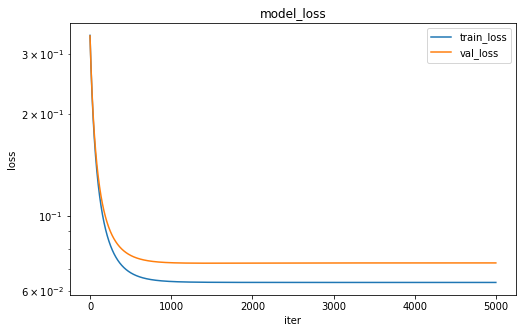

In [15]:
model.plot_loss_train_and_val()

# 【問題3】指標値の算出
分類に関する指標値で精度を確認してください。

In [16]:
y_pred = model.predict(X_test)

In [17]:
y_pred_lr = lr.predict(X_test)

In [18]:
model.accuracy(y_test, y_pred)
#スクラッチのaccuracy

1.0

In [19]:
accuracy_score(y_test,y_pred_lr)
#scikit-learnのaccuracy

1.0

# 【問題4】決定領域の可視化
2値分類のデータセットに対して決定領域を可視化してください。



決定境界
シグモイド関数は入力値に対する分類の成立確率を示す関数であるから、決定境界とはならないため別の計算式が必要となる。

シグモイド関数を fθ(x) と置いた時、次の式が成り立つ。

$$
θ^Tx >= 0 、 y = 1\\
θ^Tx < 0 、 y = 0
$$

シグモイド関数では、分類確率 0.5 が確率の中間地点となっている。
その中間地点における横軸 θTx は０であるため、シグモイド関数により算出された分類確率が 0.5 以上であれば(θTx が０以上であれば)分類Aに、それ以外であれば(θTx が０未満であれば) 分類B へ、という振り分け方で決定境界を決めることができる。

In [29]:
theta = model.coef_

In [30]:
x = np.array([1, 2])

In [31]:
X1 = - theta[2] * x[1] / theta[1]

In [32]:
X1 * theta[1] + x[1] * theta[2]

array([-4.4408921e-16])

In [33]:
X[1]

array([-1.01297765, -1.04211089])

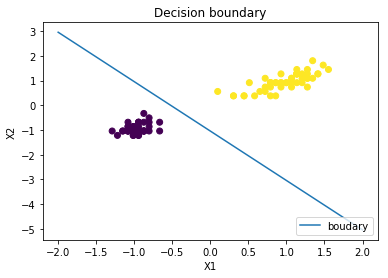

In [36]:
def validator(theta):
    #(x,y)におけるy軸。
    #シグモイド関数では θTxa=0 が分類AとBの境界だったので、その時の値を求めてプロットする。
    #θTx = θ0＊x0 + θ1＊x1 + θ2＊x2 = 0
    #x2  = -(θ0 + θ1＊x1) / θ2
    xline = np.linspace(-4,4,100) #X１の線
    budary = -(theta[0] + theta[1] + theta[2] * xline) / theta[2]

    return budary

#描画するグラフのx軸の長さ
xline = np.linspace(-2,2,100)

#決定境界の可視化
plt.plot(xline, validator(model.coef_), linestyle='solid', label='boudary')
plt.scatter(X[:,0],X[:,1], c=y)
plt.title("Decision boundary")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(loc='lower right')
plt.show()

# 【問題5】（アドバンス課題）重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやnumpy.savezを利用します。

pickle — Python オブジェクトの直列化 — Python 3.7.1 ドキュメント

numpy.savez — NumPy v1.15 Manual
https://note.nkmk.me/python-numpy-load-save-savez-npy-npz/

In [22]:
np.save("theta", model.coef_)

In [23]:
new_array = np.load('theta.npy')

In [24]:
new_array

array([[0.09958591],
       [1.56157157],
       [1.58946637]])

In [25]:
import pickle

In [26]:
with open("test.pkl", "wb") as f:
    pickle.dump(model.coef_, f) #保存

In [27]:
with open('test.pkl','rb') as f:#wb=バイナリモード　　は　”rb"
    pickle.load(f)#読み取り

In [28]:
#pandasもできる
import pandas as pd
pd.to_pickle(model.coef_, "test2.pkl")#保存
hoge = pd.read_pickle("test2.pkl") #読み出し
hoge

array([[0.09958591],
       [1.56157157],
       [1.58946637]])

# 【問題6】分類と回帰
最終発表時に以下の内容についてディスカッションを行います。自分なりの意見を用意しておいてください。

分類問題と回帰問題は本質的に何が異なっていいるか
注意点

答えがある問いではありません。いろいろな視点から見て理解を深めていきましょう。

### 意見
分類問題のプレッドはラベルで出力されるが、
確率に着目することも必要な点が注意。
間違えている部分の確率も見て考察していくと良さそう。